# Import modules

In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [2]:
import tissuetypist as tt

/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# Read in query data

MERFISH dataset from [Farah EN et al., Nature, 2024](https://www.nature.com/articles/s41586-024-07171-z)

In [4]:
path_to_adata = '/lustre/scratch126/cellgen/team205/kk18/datasets/Farah2024/overall_merfish.h5ad'
adata = sc.read_h5ad(path_to_adata)
adata

AnnData object with n_obs × n_vars = 228635 × 238
    obs: 'sample_id', 'batch', 'n_counts', 'leiden', 'zone_cluster', 'communities', 'complexity', 'populations', 'purity', 'sliding_window_assignment', 'globalX', 'globalY', 'predicted_labels_sliding_window_assignment', 'conf_score_sliding_window_assignment', 'window_col', 'window_row', 'tt_prediction'
    uns: 'communities_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'populations_colors', 'sample_id_colors', 'umap', 'zone_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Train with the gene panel of query dataset 

When predicting tissue types in imaging-based spatial transcriptomics data using a targeted gene panel (e.g., Xenium or MERFISH), we subset the reference Visium dataset to the panel’s genes and retrain the model accordingly.

### Preprocess reference dataframe with the gene panel

In [5]:
# Prepare list of genes in the panel of query dataset
gene_panel = list(adata.var_names)
print(len(gene_panel))
print(gene_panel[:5])

238
['ABCC9', 'ADAMTS6', 'ADAMTS8', 'ADGRL1', 'ADGRL2']


In [6]:
%%time
# preprocess
ref_df = tt.preprocess_builtin_reference(gene_panel=gene_panel,plot=False)
print(ref_df.shape)
ref_df.head()

Log-normalising reference data...


/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preparing expression data...
185 genes will be used.


/nfs/team205/kk18/github/TissueTypist/tissuetypist/preprocess.py:372: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for section, group_df in data.groupby('section'):


Calculating distance from tissue edge...
(19179, 377)
CPU times: user 3.87 s, sys: 1.94 s, total: 5.81 s
Wall time: 9.18 s


TENM2_own  NR2F2_own  IGFBP4_own  \
spot_id                                                                   
HCAHeartST10298114_AAACAAGTATCTCCCA-1   0.000000   3.227363    4.299178   
HCAHeartST10298114_AAACATTTCCCGGATT-1   0.000000   3.809993    3.138752   
HCAHeartST10298114_AAACGAGACGGTTGAT-1   2.910235   2.910235    0.000000   
HCAHeartST10298114_AAACTCGTGATATAAG-1   0.000000   0.000000    3.411989   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1   0.000000   0.000000    2.744449   

                                       HCN4_own   FN1_own  NEFL_own  \
spot_id                                                               
HCAHeartST10298114_AAACAAGTATCTCCCA-1  0.000000  6.079556       0.0   
HCAHeartST10298114_AAACATTTCCCGGATT-1  0.000000  5.805514       0.0   
HCAHeartST10298114_AAACGAGACGGTTGAT-1  2.910235  4.940848       0.0   
HCAHeartST10298114_AAACTCGTGATATAAG-1  0.000000  7.404418       0.0   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1  0.000000  5.626054       0.0   

                                       NKX2-5_own  RYR2_own  PROX1_own  \
spot_id                                                                  
HCAHeartST10298114_AAACAAGTATCTCCCA-1    5.138686  3.900480   3.227363   
HCAHeartST10298114_AAACATTTCCCGGATT-1    4.712905  3.138752   3.138752   
HCAHeartST10298114_AAACGAGACGGTTGAT-1    4.254824  2.910235   2.910235   
HCAHeartST10298114_AAACTCGTGATATAAG-1    0.000000  0.000000   0.000000   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1    4.765998  4.301090   0.000000   

                                       POSTN_own  ...  ADAMTS8_neighbour-max  \
spot_id                                           ...                          
HCAHeartST10298114_AAACAAGTATCTCCCA-1   5.271483  ...               3.917231   
HCAHeartST10298114_AAACATTTCCCGGATT-1   5.401553  ...               4.003023   
HCAHeartST10298114_AAACGAGACGGTTGAT-1   4.475125  ...               3.069628   
HCAHeartST10298114_AAACTCGTGATATAAG-1   4.640916  ...               4.836282   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1   3.799260  ...               3.071588   

                                       RPRM_neighbour-max  \
spot_id                                                     
HCAHeartST10298114_AAACAAGTATCTCCCA-1             0.00000   
HCAHeartST10298114_AAACATTTCCCGGATT-1             0.00000   
HCAHeartST10298114_AAACGAGACGGTTGAT-1             0.00000   
HCAHeartST10298114_AAACTCGTGATATAAG-1             2.77776   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1             0.00000   

                                       BRINP3_neighbour-max  \
spot_id                                                       
HCAHeartST10298114_AAACAAGTATCTCCCA-1              3.151512   
HCAHeartST10298114_AAACATTTCCCGGATT-1              3.786538   
HCAHeartST10298114_AAACGAGACGGTTGAT-1              2.941979   
HCAHeartST10298114_AAACTCGTGATATAAG-1              2.729593   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1              0.000000   

                                                  section    x   y  \
spot_id                                                              
HCAHeartST10298114_AAACAAGTATCTCCCA-1  HCAHeartST10298114  102  50   
HCAHeartST10298114_AAACATTTCCCGGATT-1  HCAHeartST10298114   97  61   
HCAHeartST10298114_AAACGAGACGGTTGAT-1  HCAHeartST10298114   79  35   
HCAHeartST10298114_AAACTCGTGATATAAG-1  HCAHeartST10298114  113  23   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1  HCAHeartST10298114   67  45   

                                       n_neighbours  is_edge  \
spot_id                                                        
HCAHeartST10298114_AAACAAGTATCTCCCA-1           4.0    False   
HCAHeartST10298114_AAACATTTCCCGGATT-1           4.0    False   
HCAHeartST10298114_AAACGAGACGGTTGAT-1           4.0    False   
HCAHeartST10298114_AAACTCGTGATATAAG-1           4.0    False   
HCAHeartST10298114_AAACTGCTGGCTCCAA-1           3.0     True   

                                       distance_to_edge  \
spot_id                                                   
HCAHear

The pre-processed dataframe includes:
* Gene expression data of each spot (suffix: `_own`)
* Gene expression data of neighbour spots (suffix: `_neighbour-max`)
* Section ID (`section`)
* XY coordinates (`x` and `y`)
* Distance to tissue edge (`distance_to_edge`)
* Tissue label (`tissue`)

### Train

In [7]:
%%time
dir_to_models = '/nfs/team205/kk18/notebooks/P48_Foetal-heart_Visium/notebooks/TissueTypist/tissuetypist_package_4/trained_models/Farah2024'
tt.train(ref_df,
          tissue_col='tissue',
          save_dir=dir_to_models
         )

Training...: weight to neighbour spots = 0.0, weight to edge = 0
Training...: weight to neighbour spots = 0.3, weight to edge = 5
Training...: weight to neighbour spots = 1.0, weight to edge = 5
CPU times: user 1min 40s, sys: 221 ms, total: 1min 40s
Wall time: 2min 17s


# Predict

### Preprocess query data

Below, with setting as `pseudobulk=True`, we are generating pseudo-bulk gene expression data using a sliding window approach.
Specifically, the data will be segmented into adjacent windows to match the size of the low-resolution visium data, utilising the `squidpy.tl.sliding_window` function. For each defined window, gene expression data will be aggregated through summation. The resulting aggregated counts will be then normalized and log-transformed to prepare them for further pre-processing. 

Making pseudobulk per sliding window...
### Total window number ###: 20348
### Average cell number per window ###: 11.2
Pseudobulk: summed per window and log-normalised.
Preparing expression data...
185 genes will be used.
Calculating distance from tissue edge...


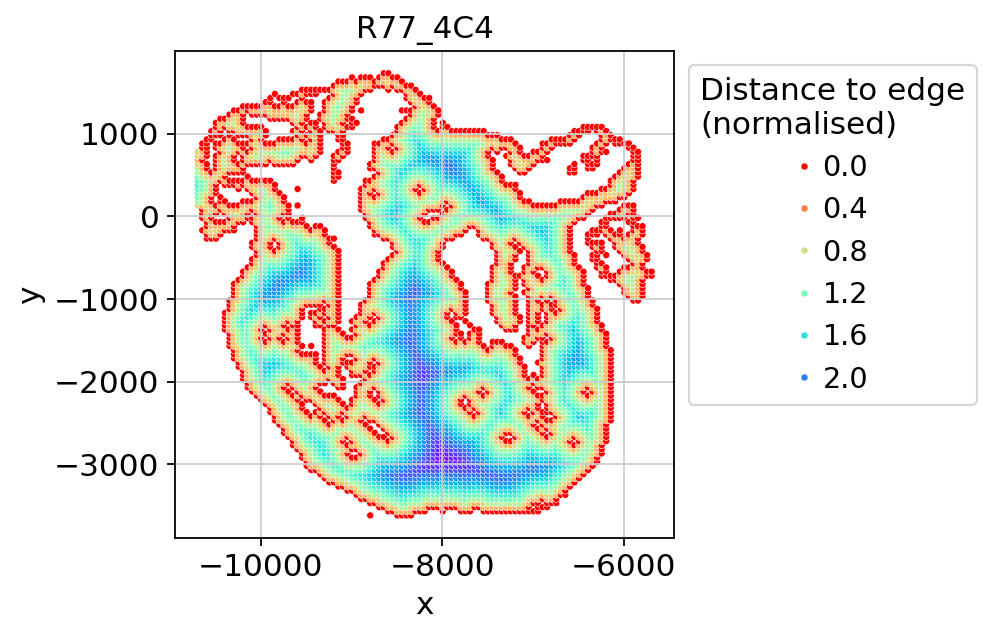

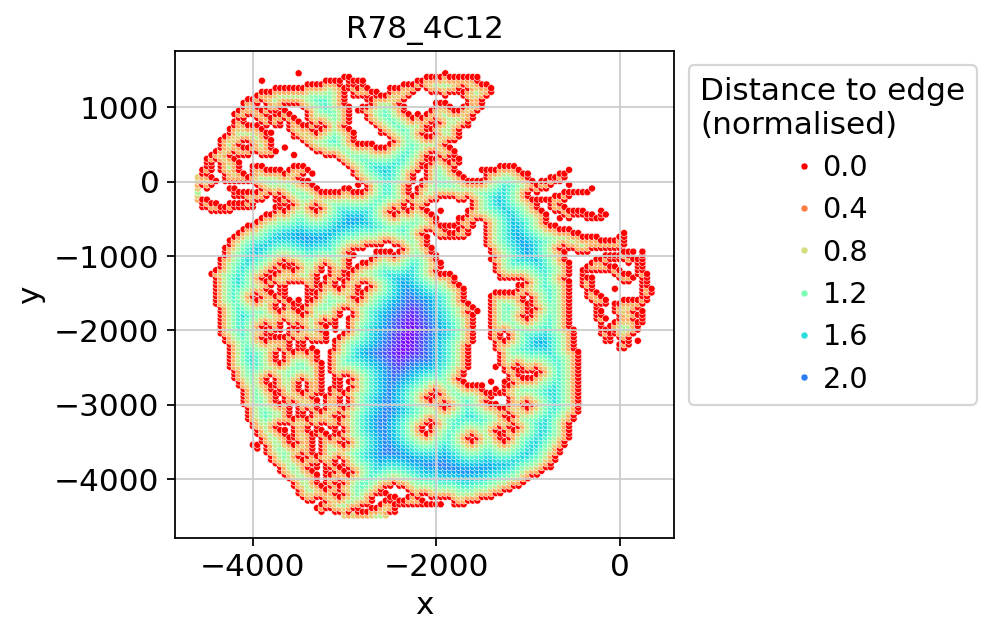

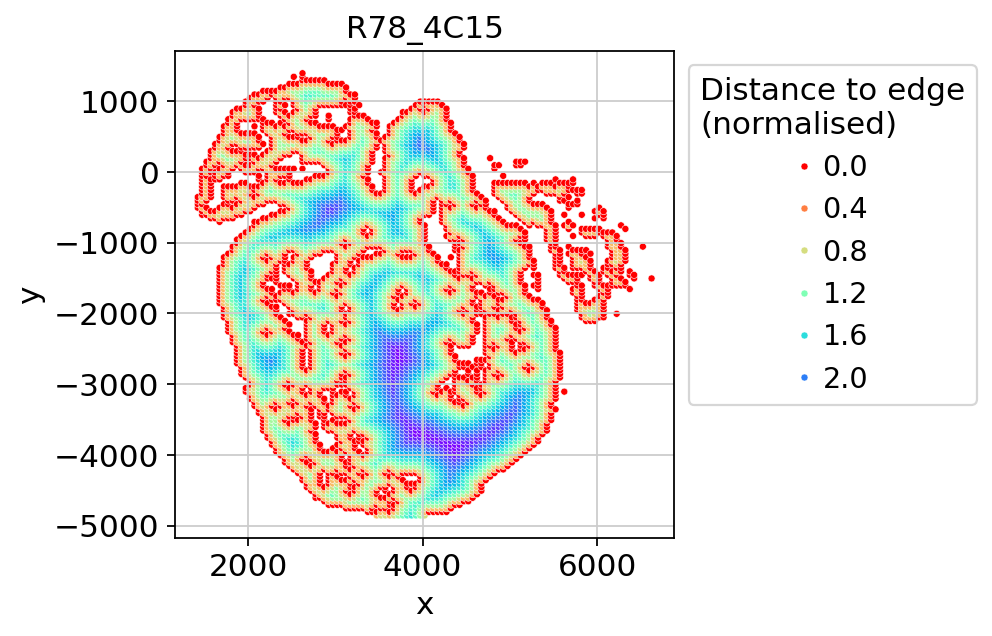

(20348, 376)
CPU times: user 2min 26s, sys: 1.16 s, total: 2min 27s
Wall time: 3min 22s


TENM2_own  NR2F2_own  IGFBP4_own  HCN4_own   FN1_own  \
R77_4C4_window_75   3.218449   4.398518    4.604950  0.000000  5.868356   
R77_4C4_window_76   2.063393   3.873390    4.847462  1.902839  5.737892   
R77_4C4_window_77   3.302085   4.546067    4.876409  3.841294  5.520409   
R77_4C4_window_78   2.498129   4.534130    4.752995  3.972727  5.411428   
R77_4C4_window_79   3.497176   4.656388    5.026740  4.440847  4.967531   

                   NEFL_own  NKX2-5_own  RYR2_own  PROX1_own  POSTN_own  ...  \
R77_4C4_window_75       0.0    2.433298  4.363281   0.000000   5.894869  ...   
R77_4C4_window_76       0.0    1.902839  3.981223   3.165095   5.678223  ...   
R77_4C4_window_77       0.0    2.759892  4.388393   2.563431   5.258080  ...   
R77_4C4_window_78       0.0    3.020254  4.443209   3.057133   5.099892  ...   
R77_4C4_window_79       0.0    3.945835  4.502683   3.241984   5.024063  ...   

                   UPK3B_neighbour-max  ADAMTS8_neighbour-max  \
R77_4C4_window_75             2.131050               4.898070   
R77_4C4_window_76             2.175452               4.898070   
R77_4C4_window_77             2.175452               4.916102   
R77_4C4_window_78             2.175452               4.916102   
R77_4C4_window_79             1.734473               4.916102   

                   RPRM_neighbour-max  BRINP3_neighbour-max  section  \
R77_4C4_window_75            3.403841              3.350281  R77_4C4   
R77_4C4_window_76            2.650873              3.350281  R77_4C4   
R77_4C4_window_77            3.403841              2.861967  R77_4C4   
R77_4C4_window_78            3.403841              3.350281  R77_4C4   
R77_4C4_window_79            2.324394              2.861967  R77_4C4   

                              x           y  n_neighbours  is_edge  \
R77_4C4_window_75 -10692.285603  130.524249           2.0    False   
R77_4C4_window_76 -10692.285603  180.524249           3.0    False   
R77_4C4_window_77 -10692.285603  230.524249           3.0    False   
R77_4C4_window_78 -10692.285603  280.524249           3.0    False   
R77_4C4_window_79 -10692.285603  330.524249           3.0    False   

                   distance_to_edge  
R77_4C4_window_75          0.776771  
R77_4C4_window_76          1.049756  
R77_4C4_window_77          1.250293  
R77_4C4_window_78          1.288166  
R77_4C4_window_79          1.384855  

[5 rows x 376 columns]

In [8]:
%%time
query_df = tt.preprocess(adata,
                     section_col='sample_id',
                     coord_columns = None,
                     pseudobulk=True,
                     pseudobulk_window_size=50,
                     tile_type='square', # 'hexagon' or 'square'
                     plot=True
                    )
print(query_df.shape)
query_df.head()

### Predict

In [9]:
%%time
query_df = tt.predict(query_df,
                  pipeline_dir=dir_to_models
                 )

Loading custom models...
Loading custom models...
Loading custom models...
##### weight2neighbours-0.0_weight2edge-0 #####
number of features: 371
predicting...
done!
##### weight2neighbours-0.3_weight2edge-5 #####
number of features: 371
predicting...
done!
##### weight2neighbours-1.0_weight2edge-5 #####
number of features: 371
predicting...
done!
CPU times: user 994 ms, sys: 491 ms, total: 1.48 s
Wall time: 2.26 s


# Plot results

In [10]:
AnnotationPalette={ 
    'Atrium':'#eac075',
        'Ventricle - Compact':'#f1acfa',
     'Ventricle - Trabeculated':'#f09951',
        'SAnode':'#8A2BE2',
        'AVnode':'#062b4a',
    'VCS - Proximal':'#FFFF00',
        'VCS - Distal':'#7FFFD4',
        'Epicardium':'#01ccc8',
        'Endocardium - Atrial':'#DC143C',
        'Endocardium - Ventricular':'#f53527',
        'Endocardial cusion':'#ff7e97',
        'Great vessel':'#ff9b6e',
    'Ductus arteriosus':'#8a6800',
        'Coronary vessel':'#206601',
        'Adventitia - Coronary':'#CAFF70',
     'Adventitia - GV':'#005aa0',
        'AV ring':'#e478ff',
    'Valves':'#3300FF',
    'LN':'#9088ff',
}

number of sections: 3


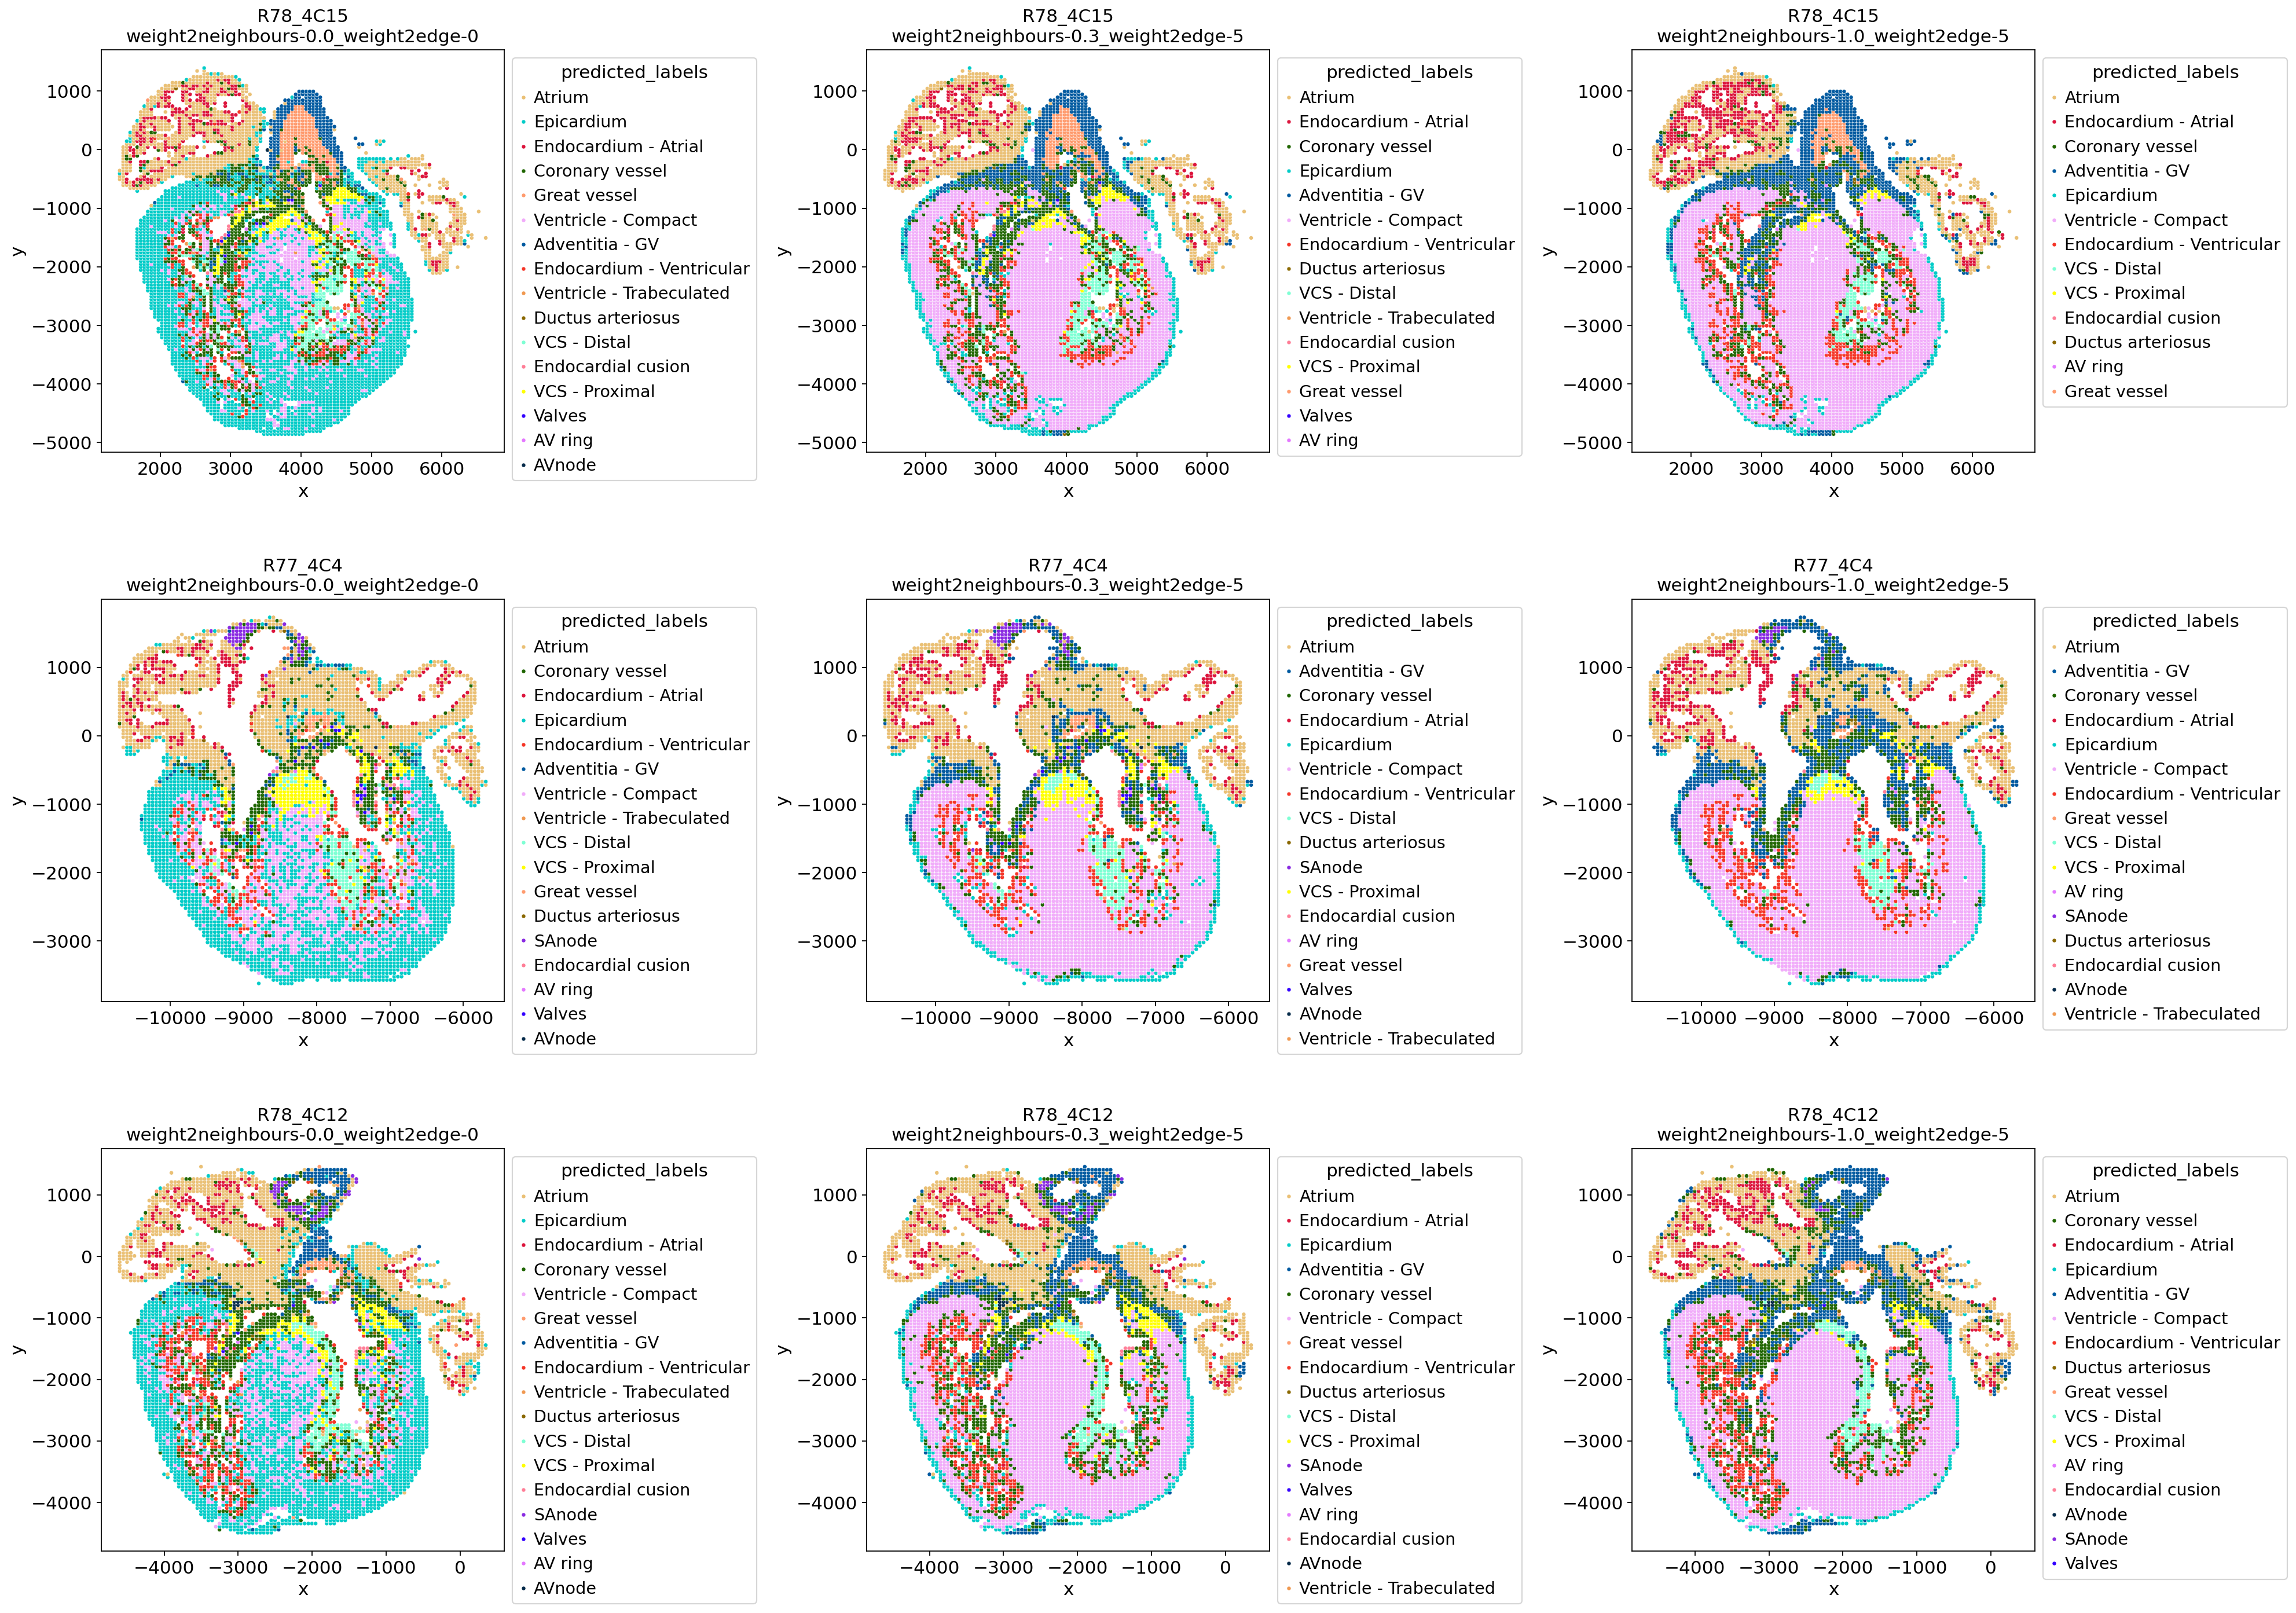

In [11]:
sections = set(query_df['section'])
print(f'number of sections: {len(sections)}')
predictions = [x for x in query_df.columns if 'predicted_labels_' in x]

plt.rcParams['axes.grid'] = False
fig, axs = plt.subplots(ncols=3,nrows=len(sections),figsize=(25,6*len(sections)))
axs = axs.flatten()
count=0
for i,section in enumerate(sections):
    # subset
    data_sub = query_df[query_df['section']==section]
    for j,col in enumerate(predictions):
        count = (i*3)+j
        pipeline_name = col.replace('predicted_labels_','')
        sns.scatterplot(
            x='x',y='y',hue=col,
            data=data_sub,
            s=10,palette=AnnotationPalette,ax=axs[count]
        )
        axs[count].set_title(f'{section}\n{pipeline_name}')
        axs[count].legend(title='predicted_labels',bbox_to_anchor=(1, 1))
fig.tight_layout()

# Select a condition and store the output to the original adata

In [12]:
adata = tt.prediction_to_adata(adata,
                         query_df,
                         weight_neighbour=0.3,
                         weight_edge=5,
                         sliding_window_col='sliding_window_assignment')
adata.obs

0 data don't have a predicted result


sample_id     batch  n_counts leiden zone_cluster  \
6-R77_4C4          R77_4C4   R77_4C4      86.0      6            4   
8-R77_4C4          R77_4C4   R77_4C4     148.0      6            1   
9-R77_4C4          R77_4C4   R77_4C4     100.0      6            1   
10-R77_4C4         R77_4C4   R77_4C4      70.0      6            1   
12-R77_4C4         R77_4C4   R77_4C4      63.0      6            1   
...                    ...       ...       ...    ...          ...   
6660345-R78_4C15  R78_4C15  R78_4C15      70.0      6            1   
6660348-R78_4C15  R78_4C15  R78_4C15      83.0     24            1   
6660352-R78_4C15  R78_4C15  R78_4C15      70.0     24            1   
6660357-R78_4C15  R78_4C15  R78_4C15     118.0      6            1   
6660363-R78_4C15  R78_4C15  R78_4C15      72.0     24            1   

                  communities  complexity populations    purity  \
6-R77_4C4         AVN/AV Ring           8         VIC  0.544534   
8-R77_4C4               Valve           8         VIC  0.625984   
9-R77_4C4               Valve           8         VIC  0.583665   
10-R77_4C4              Valve           9         VIC  0.766393   
12-R77_4C4              Valve           8         VIC  0.596838   
...                       ...         ...         ...       ...   
6660345-R78_4C15        Valve           9         VIC  0.724675   
6660348-R78_4C15        Valve           8         VEC  0.747340   
6660352-R78_4C15        Valve           7         VEC  0.771772   
6660357-R78_4C15        Valve           9         VIC  0.657963   
6660363-R78_4C15        Valve           8         VEC  0.736842   

                 sliding_window_assignment      globalX     globalY  \
6-R77_4C4              R77_4C4_window_5143 -8360.241784 -264.450337   
8-R77_4C4              R77_4C4_window_5251 -8315.434172 -251.406201   
9-R77_4C4              R77_4C4_window_5143 -8339.860841 -256.950406   
10-R77_4C4             R77_4C4_window_5360 -8253.205215 -232.544847   
12-R77_4C4             R77_4C4_window_5143 -8329.613279 -252.721762   
...                                    ...          ...         ...   
6660345-R78_4C15      R78_4C15_window_7275  4298.794536 -229.491009   
6660348-R78_4C15      R78_4C15_window_7274  4263.017184 -234.359407   
6660352-R78_4C15      R78_4C15_window_7148  4205.752231 -240.518158   
6660357-R78_4C15      R78_4C15_window_7401  4317.302263 -217.380761   
6660363-R78_4C15      R78_4C15_window_7275  4252.529929 -227.249189   

                 predicted_labels_sliding_window_assignment  \
6-R77_4C4                                    VCS - Proximal   
8-R77_4C4                                            Valves   
9-R77_4C4                                    VCS - Proximal   
10-R77_4C4                                     Great vessel   
12-R77_4C4                                           Valves   
...                                                     ...   
6660345-R78_4C15                                    AV ring   
6660348-R78_4C15                               Great vessel   
6660352-R78_4C15                               Great vessel   
6660357-R78_4C15                                    AV ring   
6660363-R78_4C15                               Great vessel   

                  conf_score_sliding_window_assignment   window_col  \
6-R77_4C4                                 4.692978e-03 -8342.285603   
8-R77_4C4                                 7.801635e-01 -8292.285603   
9-R77_4C4                                 4.692978e-03 -8342.285603   
10-R77_4C4                                1.398269e-04 -8242.285603   
12-R77_4C4                                7.801635e-01 -8342.285603   
...                                                ...          ...   
6660345-R78_4C15                          5.392217e-07  4274.500527   
6660348-R78_4C15                          2.153858e-07  4274.500527   
6660352-R78_4C15                          2.153858e-07  4224.500527   
6660357-R78_4C15                          5.392217e

In [13]:
# save adata
adata.write(path_to_adata)
path_to_adata

'/lustre/scratch126/cellgen/team205/kk18/datasets/Farah2024/overall_merfish.h5ad'